# Mengimport Library

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Memuat Dataset

Dalam rangka mengoptimalkan penggunaan memori saat membaca dataset dari file CSV menggunakan Pandas, terdapat beberapa strategi yang dapat dilakukan. Salah satunya adalah dengan melakukan pengurangan ukuran tipe data yang digunakan oleh kolom-kolom numerik.

Secara default, Pandas akan secara otomatis mendeteksi tipe data kolom saat memuat dataset. Misalnya, kolom numerik akan diassign sebagai int64, kolom float akan diassign sebagai float64, dan kolom string akan diassign sebagai objek (object dtype).

1. Membuat dictionary dtypes yang mendefinisikan tipe data kolom-kolom dataset. Setiap kolom diberikan tipe data yang sesuai menggunakan tipe data dari NumPy (seperti np.int32, np.uint8, np.float32) dan kategori (category) untuk kolom-kolom yang berisi label atau kategori.Membuat dictionary dtypes yang mendefinisikan tipe data kolom-kolom dataset. Setiap kolom diberikan tipe data yang sesuai menggunakan tipe data dari NumPy (seperti np.int32, np.uint8, np.float32) dan kategori (category) untuk kolom-kolom yang berisi label atau kategori.
2. Menggunakan metode shape pada DataFrame untuk mencetak bentuk (shape) dataset yang telah dibaca. Hasilnya akan dicetak dalam format string dengan menggunakan fungsi format().Menggunakan metode shape pada DataFrame untuk mencetak bentuk (shape) dataset yang telah dibaca. Hasilnya akan dicetak dalam format string dengan menggunakan fungsi format().  

In [2]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [3]:
dataset_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [4]:
#data yang hilang perkolom
missingValue = dataset_df.isnull().sum()

#jumlah total data yang hilang
totalCells = np.product(dataset_df.shape)
totalMissing = missingValue.sum()
percentMissing = (totalMissing/totalCells)*100

print(percentMissing)


19.0048905298737


# Memuat Label

1. Membuat kolom baru bernama 'session' dengan menggunakan metode .apply() pada kolom 'session_id'. Fungsi lambda digunakan untuk menerapkan fungsi anonim yang membagi 'session_id' berdasarkan karakter '_' dan mengambil elemen pertama (indeks 0) sebagai bilangan bulat. Hasilnya disimpan dalam kolom 'session'.
2. Membuat kolom baru bernama 'q' dengan menggunakan metode .apply() pada kolom 'session_id'. Fungsi lambda digunakan untuk menerapkan fungsi anonim yang membagi 'session_id' berdasarkan karakter '_' dan mengambil elemen terakhir (indeks -1) setelah menghilangkan karakter pertama (indeks 1) sebagai bilangan bulat. Hasilnya disimpan dalam kolom 'q'.

In [5]:
label = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
label['session'] = label.session_id.apply(lambda x: int(x.split('_')[0]) )
label['q'] = label.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
label.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [6]:
print("Full train label shape is {}".format(label.shape))

Full train label shape is (424116, 4)


# Diagram Batang untuk Kolom Label Bernilai Benar

1. Mengatur ukuran figure menggunakan fungsi figure(figsize=(10, 20)) dengan lebar 10 inci dan tinggi 20 inci.
2. Mengatur jarak antara subplot menggunakan fungsi subplots_adjust(hspace=0.5, wspace=0.5) dengan jarak vertikal (hspace) dan jarak horizontal (wspace) masing-masing 0.5.
3. Menetapkan judul utama menggunakan fungsi suptitle() dengan teks ""Correct" column values for each question" dan fontsize 14. Parameter y=0.94 digunakan untuk mengatur posisi vertikal judul.
4. Melakukan perulangan dari 1 hingga 18 menggunakan range(1, 19).
5. Pada setiap iterasi, membuat subplot baru dengan menggunakan subplot(6, 3, n), dengan 6 baris, 3 kolom, dan nomor subplot sesuai dengan nilai n.
6. Memfilter DataFrame label untuk mengambil baris yang memiliki nilai kolom 'q' sama dengan n menggunakan loc[label.q == n].
7. Menghitung jumlah nilai 'correct' yang unik dan menggambarkannya dalam bentuk diagram batang menggunakan value_counts() dan plot() dengan jenis 'bar'. Warna batang ditentukan sebagai ['b', 'c'].
8. Mengatur judul subplot dengan menggunakan set_title() dan menambahkan teks "Question" diikuti dengan nomor n dalam bentuk string.
9. Mengatur label sumbu x pada subplot menjadi kosong menggunakan set_xlabel("").

Dengan demikian, program tersebut menghasilkan subplot-grid berukuran 6x3 dengan diagram batang yang menunjukkan jumlah nilai 'correct' untuk setiap pertanyaan. Setiap subplot memiliki judul yang menunjukkan nomor pertanyaan yang sesuai.








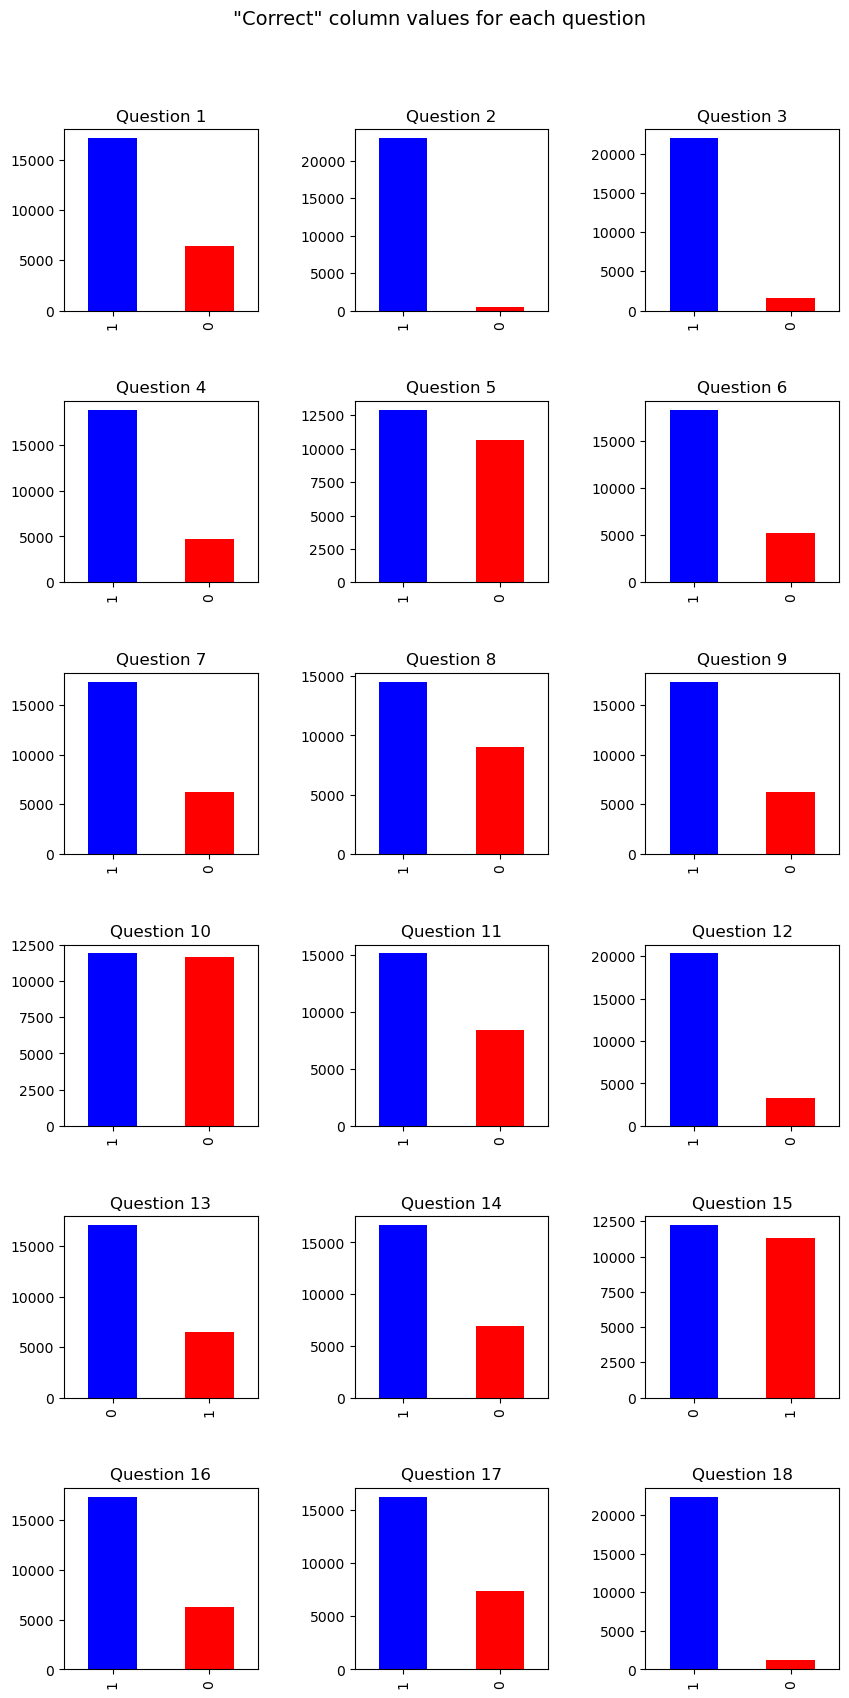

In [7]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = label.loc[label.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'r'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

# Menyiapkan Dataset

Fungsi feature_engineer melakukan beberapa operasi pemrosesan data pada DataFrame input dataset_df, seperti menghitung jumlah nilai unik dan statistik ringkasan dari fitur kategorikal dan numerikal berdasarkan kelompok 'session_id' dan 'level_group'.

In [8]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y','screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

dataset_df = feature_engineer(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

dataset_df.head(5)
# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

Full prepared dataset shape is (70686, 22)


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [9]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454849,-92.222832,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689088,183.186301,240.795420,124.016602,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784378,69.349052,...,36.971046,1.394260e+05,1.206491e+07,0.492239,0.785170,106.991644,48.884988,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440765,-409.231293,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425412,90.098533,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615677,-151.717484,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066225,143.588600,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255625,-71.538723,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901352,162.941973,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220109,-38.693486,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347609,233.385259,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347977,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257133,349.049304,612.958607,331.833790,7.837739e+07


# Distribusi Data Numerik

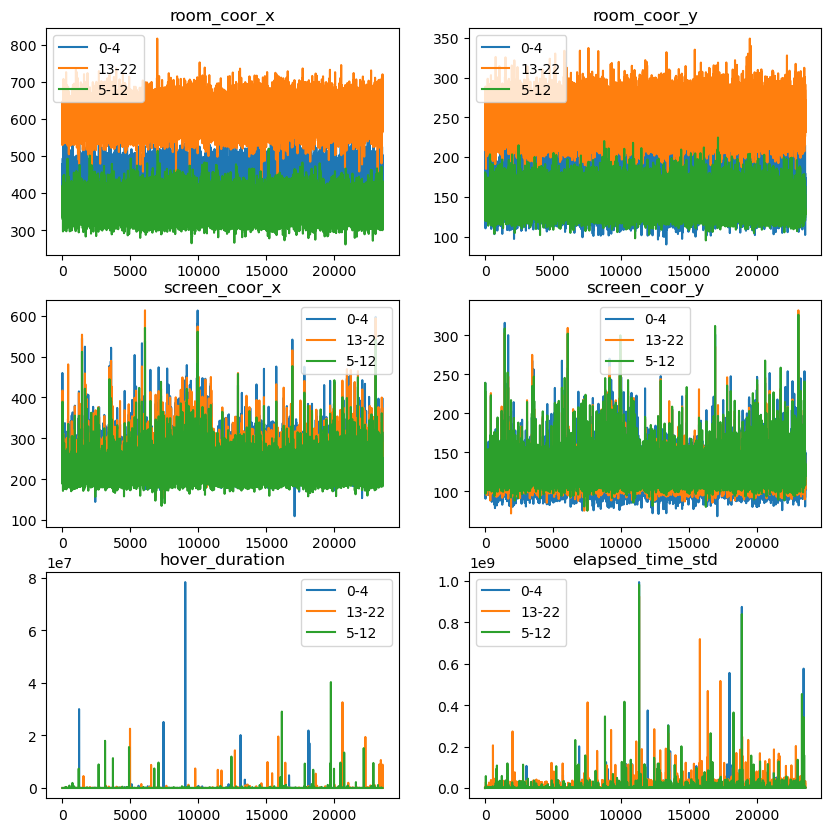

56547 examples in training, 14139 examples in testing.


In [10]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

# Membuat Model

In [11]:
rfm = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpmeuf890_ as temporary training directory


# Training

In [12]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = label.loc[label.q==q_no].set_index('session').loc[train_users]
    valid_labels = label.loc[label.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Random Forest Model with default settings. 
    # By default the model is set to train for a classification task.
    rfm = tfdf.keras.RandomForestModel(num_trees = 1000, max_depth = 8)
    rfm.compile(metrics=["accuracy"])

    # Train the model.
    rfm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = rfm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = rfm.make_inspector()
    inspector.evaluation()
    evaluation = rfm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = rfm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()     

### q_no 1 grp 0-4


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Use /tmp/tmp14mf8xs7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.811524. Found 18849 examples.
Training model...


[INFO 23-06-23 13:35:13.3443 UTC kernel.cc:1242] Loading model from path /tmp/tmp14mf8xs7/model/ with prefix 01aacb2d423b4d22


Model trained in 0:00:24.691485
Compiling model...


[INFO 23-06-23 13:35:14.1183 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 189172 node(s), and 21 input feature(s).
[INFO 23-06-23 13:35:14.1183 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:35:14.1184 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
5/5 [==============================] - 0s 41ms/step
### q_no 2 grp 0-4
Use /tmp/tmpv62trlr1 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.741553. Found 18849 examples.
Training model...


[INFO 23-06-23 13:35:52.3158 UTC kernel.cc:1242] Loading model from path /tmp/tmpv62trlr1/model/ with prefix d488d81f97e74cac


Model trained in 0:00:20.713049
Compiling model...


[INFO 23-06-23 13:35:52.8398 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 130098 node(s), and 21 input feature(s).
[INFO 23-06-23 13:35:52.8401 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:35:52.8403 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 3 grp 0-4
Use /tmp/tmp85l_1465 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.706579. Found 18849 examples.
Training model...


[INFO 23-06-23 13:36:35.6165 UTC kernel.cc:1242] Loading model from path /tmp/tmp85l_1465/model/ with prefix 2b34945e3fea4bfe


Model trained in 0:00:21.948543
Compiling model...


[INFO 23-06-23 13:36:36.2776 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 165336 node(s), and 21 input feature(s).
[INFO 23-06-23 13:36:36.2779 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:36:36.2779 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 4 grp 5-12
Use /tmp/tmpy1bhk8i1 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.711975. Found 18849 examples.
Training model...


[INFO 23-06-23 13:37:19.7688 UTC kernel.cc:1242] Loading model from path /tmp/tmpy1bhk8i1/model/ with prefix 1286545edc6d4c23


Model trained in 0:00:24.017928
Compiling model...


[INFO 23-06-23 13:37:20.5950 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 206762 node(s), and 21 input feature(s).
[INFO 23-06-23 13:37:20.5950 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:37:20.5950 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 5 grp 5-12
Use /tmp/tmp43girs8u as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.716845. Found 18849 examples.
Training model...


[INFO 23-06-23 13:38:02.6757 UTC kernel.cc:1242] Loading model from path /tmp/tmp43girs8u/model/ with prefix 6d592e1164574a3a


Model trained in 0:00:24.625246
Compiling model...


[INFO 23-06-23 13:38:03.5155 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 207696 node(s), and 21 input feature(s).
[INFO 23-06-23 13:38:03.5155 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:38:03.5156 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 6 grp 5-12
Use /tmp/tmpw6s39__v as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.724247. Found 18849 examples.
Training model...


[INFO 23-06-23 13:38:28.8453 UTC kernel.cc:1242] Loading model from path /tmp/tmpw6s39__v/model/ with prefix 09e27ad88e414ad2


Model trained in 0:00:24.144144
Compiling model...


[INFO 23-06-23 13:38:29.7038 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 204086 node(s), and 21 input feature(s).
[INFO 23-06-23 13:38:29.7039 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:38:29.7039 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 41ms/step
### q_no 7 grp 5-12
Use /tmp/tmpfserw353 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.689888. Found 18849 examples.
Training model...


[INFO 23-06-23 13:39:11.0245 UTC kernel.cc:1242] Loading model from path /tmp/tmpfserw353/model/ with prefix f99c91c3fee54a26


Model trained in 0:00:24.050704
Compiling model...


[INFO 23-06-23 13:39:11.8235 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 198988 node(s), and 21 input feature(s).
[INFO 23-06-23 13:39:11.8236 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:39:11.8236 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 8 grp 5-12
Use /tmp/tmp50w3a8qd as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:01.077258. Found 18849 examples.
Training model...


[INFO 23-06-23 13:39:52.3278 UTC kernel.cc:1242] Loading model from path /tmp/tmp50w3a8qd/model/ with prefix 53ad778778f544e4


Model trained in 0:00:22.615747
Compiling model...


[INFO 23-06-23 13:39:53.0981 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 177060 node(s), and 21 input feature(s).
[INFO 23-06-23 13:39:53.0981 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:39:53.0981 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 41ms/step
### q_no 9 grp 5-12
Use /tmp/tmpc_6lh730 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.740171. Found 18849 examples.
Training model...


[INFO 23-06-23 13:40:35.7841 UTC kernel.cc:1242] Loading model from path /tmp/tmpc_6lh730/model/ with prefix 6564488aeb0d494d


Model trained in 0:00:23.808447
Compiling model...


[INFO 23-06-23 13:40:36.5706 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 196888 node(s), and 21 input feature(s).
[INFO 23-06-23 13:40:36.5708 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:40:36.5708 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 10 grp 5-12
Use /tmp/tmp8je6mzti as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.703390. Found 18849 examples.
Training model...


[INFO 23-06-23 13:41:18.3108 UTC kernel.cc:1242] Loading model from path /tmp/tmp8je6mzti/model/ with prefix e786413bb383451a


Model trained in 0:00:24.116098
Compiling model...


[INFO 23-06-23 13:41:19.1004 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 197772 node(s), and 21 input feature(s).
[INFO 23-06-23 13:41:19.1005 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:41:19.1005 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 11 grp 5-12
Use /tmp/tmp472revcp as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.718355. Found 18849 examples.
Training model...


[INFO 23-06-23 13:41:43.5095 UTC kernel.cc:1242] Loading model from path /tmp/tmp472revcp/model/ with prefix e1d04e9c0d98493c


Model trained in 0:00:23.120558
Compiling model...


[INFO 23-06-23 13:41:44.2609 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 186142 node(s), and 21 input feature(s).
[INFO 23-06-23 13:41:44.2612 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:41:44.2615 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 42ms/step
### q_no 12 grp 5-12
Use /tmp/tmp4bq8i_hv as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.717612. Found 18849 examples.
Training model...


[INFO 23-06-23 13:42:25.1865 UTC kernel.cc:1242] Loading model from path /tmp/tmp4bq8i_hv/model/ with prefix 885651d3a4344516


Model trained in 0:00:22.445920
Compiling model...


[INFO 23-06-23 13:42:25.9094 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 178078 node(s), and 21 input feature(s).
[INFO 23-06-23 13:42:25.9095 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:42:25.9095 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 45ms/step
### q_no 13 grp 5-12
Use /tmp/tmpxt8yn35q as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.748636. Found 18849 examples.
Training model...


[INFO 23-06-23 13:42:50.7606 UTC kernel.cc:1242] Loading model from path /tmp/tmpxt8yn35q/model/ with prefix 53df6a67bdba4162


Model trained in 0:00:23.623389
Compiling model...


[INFO 23-06-23 13:42:51.5140 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 189260 node(s), and 21 input feature(s).
[INFO 23-06-23 13:42:51.5141 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:42:51.5141 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 43ms/step
### q_no 14 grp 13-22
Use /tmp/tmpjd7g1fyc as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.715225. Found 18849 examples.
Training model...


[INFO 23-06-23 13:43:17.1861 UTC kernel.cc:1242] Loading model from path /tmp/tmpjd7g1fyc/model/ with prefix 48f09adf9f694277


Model trained in 0:00:24.522500
Compiling model...


[INFO 23-06-23 13:43:18.0026 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 201614 node(s), and 21 input feature(s).
[INFO 23-06-23 13:43:18.0027 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:43:18.0027 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 43ms/step
### q_no 15 grp 13-22
Use /tmp/tmp0rr_no3c as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.738249. Found 18849 examples.
Training model...


[INFO 23-06-23 13:43:43.8389 UTC kernel.cc:1242] Loading model from path /tmp/tmp0rr_no3c/model/ with prefix c6ddacafcda842f3


Model trained in 0:00:24.589009
Compiling model...


[INFO 23-06-23 13:43:44.6598 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 204180 node(s), and 21 input feature(s).
[INFO 23-06-23 13:43:44.6599 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:43:44.6599 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 57ms/step
### q_no 16 grp 13-22
Use /tmp/tmp34m52gj6 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:01.042989. Found 18849 examples.
Training model...


[INFO 23-06-23 13:44:25.6337 UTC kernel.cc:1242] Loading model from path /tmp/tmp34m52gj6/model/ with prefix df4ce9dc7e44471c


Model trained in 0:00:22.706978
Compiling model...


[INFO 23-06-23 13:44:26.2234 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 144116 node(s), and 21 input feature(s).
[INFO 23-06-23 13:44:26.2234 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:44:26.2235 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 41ms/step
### q_no 17 grp 13-22
Use /tmp/tmpklqvmrl5 as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.719508. Found 18849 examples.
Training model...


[INFO 23-06-23 13:45:07.7880 UTC kernel.cc:1242] Loading model from path /tmp/tmpklqvmrl5/model/ with prefix 9568dc640257443f


Model trained in 0:00:22.683099
Compiling model...


[INFO 23-06-23 13:45:08.4751 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 167372 node(s), and 21 input feature(s).
[INFO 23-06-23 13:45:08.4752 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:45:08.4752 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 41ms/step
### q_no 18 grp 13-22
Use /tmp/tmpem3i4fuq as temporary training directory
Reading training dataset...


/tmp/ipykernel_18/3845953874.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_18/3845953874.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


Training dataset read in 0:00:00.718144. Found 18849 examples.
Training model...


[INFO 23-06-23 13:45:50.7058 UTC kernel.cc:1242] Loading model from path /tmp/tmpem3i4fuq/model/ with prefix 918cbe70189c4873


Model trained in 0:00:23.237451
Compiling model...


[INFO 23-06-23 13:45:51.3737 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 167294 node(s), and 21 input feature(s).
[INFO 23-06-23 13:45:51.3738 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 13:45:51.3738 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 50ms/step


# Periksa Akurasi Model

In [13]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7316
question 2: accuracy 0.9756
question 3: accuracy 0.9351
question 4: accuracy 0.7935
question 5: accuracy 0.6287
question 6: accuracy 0.7885
question 7: accuracy 0.7456
question 8: accuracy 0.6367
question 9: accuracy 0.7645
question 10: accuracy 0.6049
question 11: accuracy 0.6569
question 12: accuracy 0.8701
question 13: accuracy 0.7187
question 14: accuracy 0.7365
question 15: accuracy 0.5994
question 16: accuracy 0.7492
question 17: accuracy 0.7036
question 18: accuracy 0.9516

Average accuracy 0.7550392482015822


# Visualisasi

In [14]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

In [15]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


[("room_fqid_nunique" (1; #16), 245.0),
 ("name_nunique" (1; #9), 167.0),
 ("page" (1; #10), 165.0),
 ("page_std" (1; #11), 156.0),
 ("elapsed_time" (1; #1), 92.0),
 ("elapsed_time_std" (1; #2), 62.0),
 ("event_name_nunique" (1; #3), 51.0),
 ("level" (1; #7), 25.0),
 ("text_fqid_nunique" (1; #21), 18.0),
 ("screen_coor_y_std" (1; #20), 7.0),
 ("fqid_nunique" (1; #4), 6.0),
 ("level_std" (1; #8), 5.0),
 ("room_coor_y_std" (1; #15), 1.0)]

# Menentukan Threshold

Mencari nilai ambang (threshold) terbaik yang menghasilkan skor F1 (F1 score) tertinggi. Program ini menggunakan serangkaian nilai ambang yang berbeda dan menghitung skor F1 menggunakan metrik F1Score dari TensorFlow Addons (tfa.metrics.F1Score) dengan variasi nilai ambang tersebut.

In [16]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = label.loc[label.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.7900000000000004 	F1 score  0.6637545


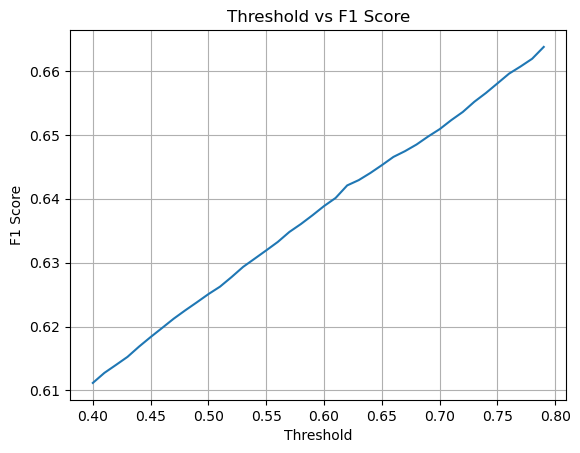

In [17]:
thresholds = np.arange(0.4, 0.8, 0.01)
f1_scores = []

for threshold in thresholds:
    metric = tfa.metrics.F1Score(num_classes=2, average="macro", threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1)) > threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    f1_scores.append(f1_score)

# Plot the threshold vs F1 score
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score")
plt.grid(True)
plt.show()

# Submission

In [18]:
# Reference
# https://www.kaggle.com/code/philculliton/basic-submission-demo
# https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook


import jo_wilder_310
env = jo_wilder_310.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineer(test)
    grp = test_df.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        rfm = models[f'{grp}_{t}']
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.loc[:, test_df.columns != 'level_group'])
        predictions = rfm.predict(test_ds)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        n_predictions = (predictions > best_threshold).astype(int)
        sample_submission.loc[mask,'correct'] = n_predictions.flatten()
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 75ms/step
